[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pranavm19/SBI-Tutorial/blob/main/notebooks/02_NFlows.ipynb)

Outline

1. What are normalizing flow, and how do they work (math + intuition building)
2. The I/O of normalizing flows - what do we want them to do?
2. Build an affine coupling layer
3. Normalizing flows using affine coupling layers and permutation masks
4. Performing inference

Vanilla conditional normalizing flows : we care about generating novel (x, y) points given context.  
Neural Posterior Estimation : we care about inferring context given novel (x, y) points. Basically, we flip the data and context over from the vanilla flow!

In [1]:
# !python -m pip install sbi corner

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

Let's make a two-moons dataset, and collect the moon "labels" for each sample.

We will use this dataset throughout this notebook to showcase how (conditional) normalizing flows work!

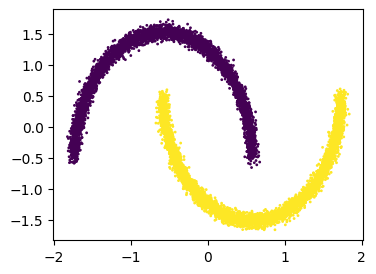

In [5]:
# Generate data; wrap inputs and context into TensorDataset and DataLoader objects
class MoonsDataset(Dataset):
    def __init__(self, n_samples=1000):
        samples, moon_ids = make_moons(n_samples, noise=0.03)
        self.mean = samples.mean(axis=0)
        self.std = samples.std(axis=0) + 1e-8
        samples = (samples - self.mean) / self.std

        self.x = torch.from_numpy(samples.astype(np.float32))
        self.context = torch.from_numpy(moon_ids[:, None].astype(np.float32))
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.context[idx]

moons = MoonsDataset(n_samples=10000)
dataloader = DataLoader(moons, batch_size=128, shuffle=True)

plt.figure(figsize=[4, 3])
plt.scatter(moons.x[:, 0], moons.x[:, 1], c=moons.context, s=1);

#### What are normalizing flows?


#### Change of variables formula


#### Transforming a data distribution to a base density



In [ ]:
# 

#### The API

Cool, so we have seen how a bijective transform can be used to "normalize" a given density. Let's make them a bit more powerful 💪

There are two components to a normalizing flow : the bijective transform (or a set of them), and the prior distribution. Once we have these, at train time, we can compute z given a batch of (x, context), and evaluate the loss. At test time, we can draw a sample from (z, context), and generate samples from the learned data distribution x (and evaluate the probability density!!). To do this, we will need:

`NF = NormalizingFlow(flows, prior)`
- `NF.forward(x, context) -> z, ldj`, 
- `NF.sample(z, context) -> x, ldj`

The `flows` object is usually a list of layers each of which is a bijective transform:

`T = AffineCouplingTransform()`
- `T.forward(x, context) -> z, ldj`, `T.inverse(z, context) -> x, ldj`

#### Real NVP - Affine Coupling Flows

The base density is quite clear, but how do we design the bijector? Especially one that is non-linear?

Real NVP - scale and shift networks

Cool, but how the hell is this non-linear and invertible? We're just scaling a shifting (so linear) and then half of the dimensions are being non-linearly transformed, so not invertible?!



In [3]:
class AffineCouplingLayer(nn.Module):
    def __init__(self, input_dim, context_dim):
        super().__init__()
        self.input_dim = input_dim
        self.context_dim = context_dim
        self.split_idx = input_dim - (input_dim // 2) # first part gets more dims if input_dim is odd

        # Define scale and shift networks
        self.scale_net = nn.Sequential(
            nn.Linear(self.split_idx + context_dim, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 64), 
            nn.LeakyReLU(),
            nn.Linear(64, input_dim - self.split_idx)
        )
        self.shift_net = nn.Sequential(
            nn.Linear(self.split_idx + context_dim, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 64), 
            nn.LeakyReLU(),
            nn.Linear(64, input_dim - self.split_idx)
        )

    def forward(self, x, context):
        # Split input tensor along the last dimension
        x_identity = x[..., :self.split_idx]
        x_transform = x[..., self.split_idx:]

        # Concatenate identity and context for both networks
        identity_context = torch.cat((x_identity, context), dim=-1)
        scale = self.scale_net(identity_context)
        shift = self.shift_net(identity_context)

        # Affine transformation on x_transform
        z_transform = x_transform * torch.exp(scale) + shift

        # Concatenate unchanged part with transformed part
        z = torch.cat((x_identity, z_transform), dim=-1)
        # Compute log-determinant of the Jacobian (sum of scale)
        ldj = torch.sum(scale, dim=-1)
        return z, ldj
    
    def inverse(self, z, context):
        # Inverse transform: split z into identity and transformed parts
        z_identity = z[..., :self.split_idx]
        z_transform = z[..., self.split_idx:]
        identity_context = torch.cat((z_identity, context), dim=-1)
        scale = self.scale_net(identity_context)
        shift = self.shift_net(identity_context)
        # Inverse affine transformation
        x_transform = (z_transform - shift) * torch.exp(-scale)
        x = torch.cat((z_identity, x_transform), dim=-1)
        ldj = -torch.sum(scale, dim=-1)
        return x, ldj


In [4]:
class NormalizingFlow(nn.Module):
    """
    A normalizing flow model composed of a sequence of affine coupling layers and a prior distribution.
    """
    def __init__(self, flows, prior=None):
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.dim = self.flows[0].input_dim
        # Initialize the prior distribution (device will be set correctly later)
        if prior is None:
            self.prior = torch.distributions.MultivariateNormal(
                torch.zeros(self.dim), torch.eye(self.dim))
        else:
            self.prior = prior

        self.train_loss = []

    def forward(self, x, context):
        """
        Applies a sequence of flow transformations and accumulates the log-determinants.
        """
        ldj = torch.zeros(x.shape[0], device=x.device)
        for flow in self.flows:
            x, ldj_ = flow(x, context)
            ldj += ldj_
        return x, ldj

    def inverse(self, z, context):
        """
        Inverts the flow transformation from latent space back to the input space.
        """
        ldj = torch.zeros(z.shape[0], device=z.device)
        for flow in reversed(self.flows):
            z, ldj_ = flow.inverse(z, context)
            ldj += ldj_  # log-determinants are already negated in inverse
        return z, ldj

    @torch.no_grad()
    def sample(self, num_samples, context):
        """
        Generate samples from the model given a context.
        """
        device = next(self.parameters()).device
        z = self.prior.sample((num_samples,)).to(device)
        x, _ = self.inverse(z, context)
        return x

    def log_prob(self, x, context): 
        """
        Compute the log probability of x under the flow model.
        """
        z, ldj = self(x, context)
        log_pz = self.prior.log_prob(z)
        return log_pz + ldj


In [5]:
class PermutationLayer(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        # Create a random permutation for the feature indices.
        perm = torch.randperm(num_features)
        self.register_buffer("perm", perm)
        self.register_buffer("inv_perm", torch.argsort(perm))
    
    def forward(self, x, context):
        # Permuting the features; no effect on the log-determinant.
        x_permuted = x[..., self.perm]
        # Log-determinant is zero for a permutation
        log_det = torch.zeros(x.size(0), device=x.device)
        return x_permuted, log_det
    
    def inverse(self, x, context):
        # Inverse permutation
        x_inv = x[..., self.inv_perm]
        log_det = torch.zeros(x.size(0), device=x.device)
        return x_inv, log_det


In [37]:
# Handle dimensions
input_dim = 2
context_dim = 1
n_layers = 4
flows = []

# Define the model and optimizer
for i in range(n_layers):
    flows.append(AffineCouplingLayer(input_dim, context_dim))
    flows.append(PermutationLayer(input_dim))

model = NormalizingFlow(flows)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [8]:
from IPython.display import clear_output, display

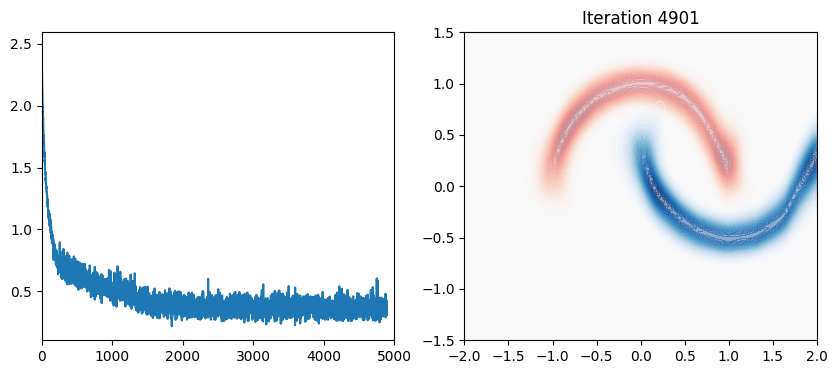

In [38]:
# Train and visualize
plt.ion()
num_iter = 5000
num_update_iter = 100
losses = []

# Create a single figure with two subplots: left for loss, right for densities
fig, (ax_loss, ax_density) = plt.subplots(1, 2, figsize=(10, 4))
# plt.show(block=False)

# Create a grid for evaluating densities
n_samples = 100
xline = torch.linspace(-2, 2, n_samples)
yline = torch.linspace(-1.5, 1.5, n_samples)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

for i in range(num_iter):
    # Generate a fresh batch of data
    x, y = make_moons(256, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    
    # Standard training step
    optimizer.zero_grad()
    loss = -model.log_prob(x, y).mean()
    loss.backward()
    optimizer.step()

    # Store the loss for plotting
    losses.append(loss.item())
    
    # Pretty plots
    if i % num_update_iter == 0:
        ax_loss.cla()  # Clear old content
        ax_density.cla()

        ax_loss.plot(losses, label='Train Loss')
        ax_loss.set_xlim([0, num_iter])  # Fix x-axis range to total iterations
        
        with torch.no_grad():
            # Evaluate density for both contexts
            zgrid0 = model.log_prob(xyinput, torch.zeros_like(ygrid.reshape(-1,1))).exp()
            zgrid1 = model.log_prob(xyinput, torch.ones_like(ygrid.reshape(-1,1))).exp()

        # We can overlay the two densities with different colormaps and alpha
        ax_density.contourf(
            xgrid.numpy(), ygrid.numpy(), zgrid0.reshape(n_samples, n_samples).numpy(),
            levels=50, cmap='Reds', alpha=0.5)
        ax_density.contourf(
            xgrid.numpy(), ygrid.numpy(), zgrid1.reshape(n_samples, n_samples).numpy(),
            levels=50, cmap='Blues', alpha=0.5)
        ax_density.set_title(f'Iteration {i + 1}')

        clear_output(wait=True)
        display(fig)
        
        plt.pause(0.01)


0

So, we've successfully trained a conditional neural density estimator!! We can now sample from whichever moon we want and at the same time evaluate the probability density of that sample!

This is fantastic! But, what we want to do is the opposite. We want to infer which moon a sample is from! We can do multiple things here -- 
1. Since we already have 

#### Solutions:  

A1.  
A2.  
A3.  
A4.  
A5.  
A6.  

References


What are some of the things I still don't understand?

- What is special about invertible mappings? What if we had a non-invertible mapping? Could we never get logprob?
- Why is it possible for us to train a bijective mapping using the masking/ splitting approach? 
- How are we getting the required flexibility to do non-linear transformations? For example, why the hell is a 2-D Gaussian distribution turning into a weird bi-modal twomoons distribution?
- What are the 

- Q. Do I go into details about amortized inference?
- 